# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve Tiny ImageNet image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch
from torch import nn

import torch.nn.functional as F
from torch.autograd import Variable

import time
import numpy as np
import tqdm

import pandas as pd
import os
import shutil
import glob

from sklearn.metrics import accuracy_score

from IPython.display import clear_output

%matplotlib inline

In [2]:
from tiny_img import download_tinyImg200

#data_path = '.'
#download_tinyImg200(data_path)

# Datasets preparation

At first step prepare datasets folders: create new `train` and `val` from original `train` dataset. Reformat original `val` dataset to new format: separate folder per each class.

In [3]:
np.random.seed(15)
val_size = 0.1

In [4]:
shutil.rmtree('tiny-imagenet-200/shad/')

for image_path in tqdm.tqdm_notebook(glob.glob("tiny-imagenet-200/train/*/images/*")):
    image_name = os.path.basename(image_path)
    label = image_path.split("/")[2]
    
    if np.random.rand() <= val_size:
        image_dir = "tiny-imagenet-200/shad/val/{}".format(label)
    else:
        image_dir = "tiny-imagenet-200/shad/train/{}".format(label)
        
    os.makedirs(image_dir, exist_ok=True)
    shutil.copyfile(image_path, "{}/{}".format(image_dir, image_name))

In [5]:
data = pd.read_csv("tiny-imagenet-200/val/val_annotations.txt", header=None, sep="\t")

for img, label in tqdm.tqdm_notebook(zip(data[0], data[1])):
    os.makedirs("tiny-imagenet-200/shad/test/{}".format(label), exist_ok=True)
    shutil.copyfile("tiny-imagenet-200/val/images/{}".format(img),
             "tiny-imagenet-200/shad/test/{}/{}".format(label, img))

# Training

In [30]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [31]:
device = torch.device("cuda:0")
num_classes = 200

In [32]:
batch_size = 512

In [33]:
imagenet_means = (0.4914, 0.4822, 0.4465)
imagenet_stds = (0.2023, 0.1994, 0.2010)

In [34]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=56),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_means, imagenet_stds),
])

In [35]:
transform_test = transforms.Compose([
    transforms.CenterCrop(56),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_means, imagenet_stds)
])

In [36]:
train_dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/shad/train', transform=transform_train)
val_dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/shad/val', transform=transform_test)

In [37]:
train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [44]:
model = nn.Sequential(
    
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    
    nn.MaxPool2d(kernel_size=2),
    
    nn.Conv2d(32, 48, kernel_size=3, padding=1),
    nn.BatchNorm2d(48),
    nn.ReLU(inplace=True),
    nn.Conv2d(48, 48, kernel_size=3, padding=1),
    nn.BatchNorm2d(48),
    nn.ReLU(inplace=True),
    nn.Conv2d(48, 48, kernel_size=3, padding=1),
    nn.BatchNorm2d(48),
    nn.ReLU(inplace=True),
    
    nn.MaxPool2d(kernel_size=2),
    
    nn.Conv2d(48, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    
    nn.MaxPool2d(kernel_size=2),
    
    nn.Conv2d(64, 96, kernel_size=3, padding=1),
    nn.BatchNorm2d(96),
    nn.ReLU(inplace=True),
    nn.Conv2d(96, 96, kernel_size=3, padding=1),
    nn.BatchNorm2d(96),
    nn.ReLU(inplace=True),
    nn.Conv2d(96, 96, kernel_size=3, padding=1),
    nn.BatchNorm2d(96),
    nn.ReLU(inplace=True),
    
    nn.MaxPool2d(kernel_size=2),
    
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(864, 864),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(864, num_classes)
)

In [45]:
%%capture
model.to(device)

In [46]:
opt = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)
critertion =  criterion = nn.CrossEntropyLoss()

In [53]:
num_epochs = 10

In [48]:
train_losses, val_losses, val_accs = [], [], []

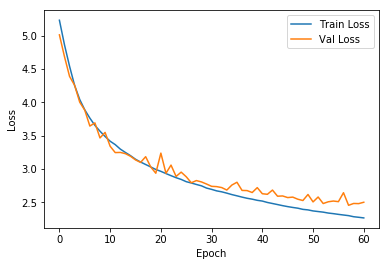

Epoch 10 of 10 took 146.839s
  training loss (in-iteration): 	2.2656
  validation loss (in-iteration): 	2.5005
  validation accuracy: 			39.09 %


In [60]:
for epoch in range(num_epochs):
    start_time = time.time()
    
    # train
    
    model.train(True)
    epoch_train_losses = []
    for (X_batch, y_batch) in tqdm.tqdm_notebook(train_batch_gen):
        logits = model(torch.FloatTensor(X_batch).to(device))
        loss = criterion(logits, torch.LongTensor(y_batch).to(device))
        
        loss.backward()
        opt.step()
        
        opt.zero_grad()
        
        epoch_train_losses.append(loss.cpu().item())
        
    train_losses.append(np.mean(epoch_train_losses))
    
    # validation
    
    model.train(False)
    epoch_val_losses, epoch_val_accs = [], []
    for X_batch, y_batch in tqdm.tqdm_notebook(val_batch_gen):
        
        logits = model(torch.FloatTensor(X_batch).to(device))
        loss = criterion(logits, torch.LongTensor(y_batch).to(device))
        
        y_pred = logits.max(1)[1].data
        
        epoch_val_losses.append(loss.cpu().item())
        epoch_val_accs.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))
    
    val_losses.append(np.mean(epoch_val_losses))
    val_accs.append(np.mean(epoch_val_accs))
    
    clear_output()
    
    plt.plot(range(len(train_losses)), train_losses, label="Train Loss")
    plt.plot(range(len(val_losses)), val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.4f}".format(
        np.mean(epoch_train_losses)))
    print("  validation loss (in-iteration): \t{:.4f}".format(
        np.mean(epoch_val_losses)))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(epoch_val_accs) * 100))

# Testing

In [61]:
test_dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/shad/test', transform=transform_test)
test_batch_gen = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [62]:
model.train(False)

y_true, y_pred = [], []
for X_batch, y_batch in tqdm.tqdm_notebook(test_batch_gen):

    logits = model(torch.FloatTensor(X_batch).to(device))
    y_predicted = logits.max(1)[1].cpu().numpy()
    
    y_true += list(y_batch.numpy())
    y_pred += list(y_predicted)

In [63]:
test_accuracy = accuracy_score(y_true, y_pred)

In [64]:
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 40:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 35:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 30:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 25:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		40.43 %
Achievement unlocked: 110lvl Warlock!


```

```

```

```

```

```


# Report

### Hi, my name is `senior Dima`, and here's my story

A long time ago in a galaxy far far away, when it was still more than an hour before the deadline, i got an idea:

##### I gonna build a neural network, that
classify TinyImageNet data. I decided to use Deep Convolutional Network with a lot of Conv2D, BatchNorm, ReLU and MaxPooling layers.

##### One day, with no signs of warning,
Actually I started with not so deep network. Tried several Conv2D (3x3 kernels) layers with ReLU and single BatchNorm, finished with MaxPooling layer. Network trained fast but validation accuracy was not so good (around 30%) after going on plateu. So I decided to do some more sophisticated things. I looked at different previous SOTA networks, tried torchvision zoo, looked that it work good (especially Resnet family) and after some experiments constructed own network based on VGG family style.

##### Finally, after __  iterations, __ mugs of water

So, my final Network has Convolutional feature extractor consists of four blocks with Conv2D layers (with ReLU and BatchNorm) separated by MaxPooling2D layers. Deeper Conv2D layers have more channels. The last layers is several fully connected layers separated by ReLU and Dropout. I applied SGD optimizer with momentum and add weight_decay (L2 regularization) while computing loss. Additionally I applied minor data augmentation: random horizontal flip and random crop of 56x56 frame from original image, at test step I used CenterCrop with the same size.

That, having wasted one Saturday and 1000 iterations of my life training, got

* accuracy on training: didn't measure, calc just loss
* accuracy on validation: 39.09%
* accuracy on test: *40.43%* (warlock!)


Thanks for your attention!